## Supervised Learning
## Project: Finding Donors for *CharityML*

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [11]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

In [12]:
# Total number of records
n_records = data.shape[0]

# # Number of records where individual's income is more than $50,000
# n_greater_50k = data.loc[data['income'] == '>50K'].shape[0]

# # Number of records where individual's income is at most $50,000
# n_at_most_50k = data.loc[data['income'] == '<=50K'].shape[0]

#you can access dataframes with dot notation
#value_counts() Returns object containing counts of unique values.
n_at_most_50k, n_greater_50k = data.income.value_counts()

# Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k/n_records) * 100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

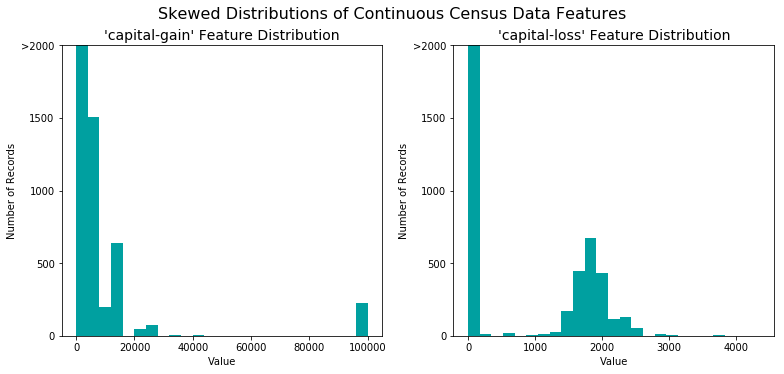

In [13]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

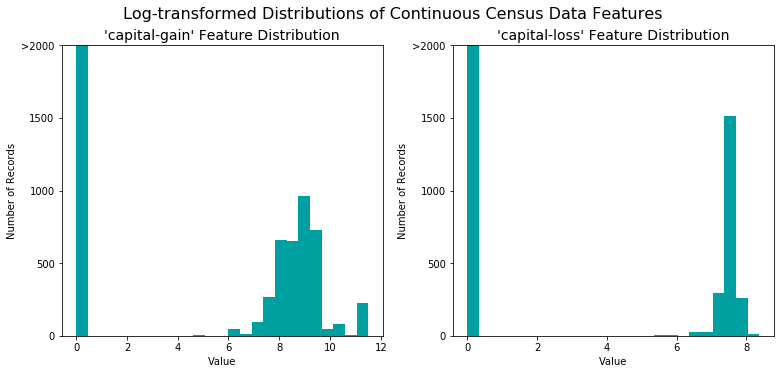

In [14]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.


In [15]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. 

In [16]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(data = features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw.eq('>50K').mul(1)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
# print(encoded)

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [17]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

In [23]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# true positives
TP = n_greater_50k
#false positives
FP = n_at_most_50k
#false negatives
FN = 0

# Calculate accuracy, precision and recall
accuracy = TP/n_records
recall = TP/(TP + FN)
precision = TP/(TP+FP)

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1 + 0.5**2)*((precision * recall)/((0.5**2 * precision)+recall))

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: **

- **Logistic Regression**
    1. Logistic Regression can be used in order to predict a student's admission into a university. The output will be a binary variable (admitted or not admitted) and the model can take in many features(HighSchool GPA, number of extracurricular activities, etc). Data will be taken from students that were admitted to the university and those who were not in order to create the model. (http://www.eajournals.org/wp-content/uploads/Application-of-Logistic-Regression-Model-to-Admission-Decision-of-foundation-Programme-at-University-of-Lagos..pdf)
    2. Logistic Regression does not require too many computational resources and does not take long to train. Furthemore, it is also very fast at the prediction step. The model performs well with binary classification problems(problems that only require the output to be a true or false answer).  
    3. The basic implementation of Logistic Regression can only output a binary variable. Although there are some techniques that allow Logistic Regression to perform multiclass classification(One versus all or one versus one methods) these methods are usally not the best performing. Because it's output is discrete it can only predict a categorical outcome. This also means that Logistic Regression must have data that can be seperable into two parts. Furthermore, there should not be high correlation between independent variables. In other words, one should avoid features that can be linearly predicted from other features in the data set. Logistic Regression is also prone to overfitting if there are too many independent variables.
    4. Logistic Regression is perfect for this problem since we only require a binary output (<=50K or >50K). Furthermore, we also don't have features with high correlation between one another. We also do not have a large amount of features that will cause the model to overfit.  
- **K-Nearest Neighbors (K-NN)**
    1. K-Nearest Neighbors can be used in recommending systems like Search Engines. The Search Engine can take a query, find the document or documents that are related to that query and recommend them to the user. K-Nearest Neighbors in this case will predict the documents that the user will find most useful.
    2. K-NN is a lazy learner since it does not generalize the data at the time of training. K-NN simply stores the data in order to be queried during the prediction step. This allows for a very fast training step and also means that it does not make any assumptions about the data. This allows K-NN to work very well with non-linear data unlike other models like Linear Regression. This non-parametric behavior also allows us to easily add new data to our model. Furthermore, K-NN can also be used in classification problems or regression ones. 
    3. The drawbacks with K-NN is that it's computationally expensive. One must store all the data in order to be able to query it later. This causes problems when the data you are training the model on is very large. Furthermore, it is also very sensitive to outliers or irrelevant features due to the prediction being dependent on the data itself. 
    4. According to our data we are looking to predict income based on some features (race, sex, etc). Therefore, we assume that people with similar income have similar values for these features. K-NN will work if this assumption is true since it will determine the income based on it's closest neighbors which have similar features. 
- **Ensemble Method(Bagging)**
    1. Bagging can be applied in the banking industry for fraud detection. Because most bank transactions are not fraudulant the model must be careful in deciding what to mark as fraud. This is why probabilistic models like Ensemble Methods are often used in fraud detection. It allows for higher amounts of accuracy and precision by combining multiple classifiers using probability. (https://www.sciencedirect.com/science/article/pii/S0957417412006215)
    2. Bagging performs extremely well with data that has outliers or a lot of noise. It reduces variance in order to avoid overfitting. Works well without needing to tune parameters too much. 
    3. Bagging is computationally expensive. One also looses the ability to interpret the model since Bagging is a very complex model.
    4. According to the problem, we care about accuracy and precision very much. Furthermore, because there may be many outliers, since income can depend on more features than the ones used in the data, Bagging may perform better than other classifiers.

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.

In [19]:
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, 0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, 0.5)

    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation

LogisticRegression trained on 362 samples.
LogisticRegression trained on 3618 samples.
LogisticRegression trained on 36177 samples.
KNeighborsClassifier trained on 362 samples.
KNeighborsClassifier trained on 3618 samples.
KNeighborsClassifier trained on 36177 samples.
BaggingClassifier trained on 362 samples.
BaggingClassifier trained on 3618 samples.
BaggingClassifier trained on 36177 samples.


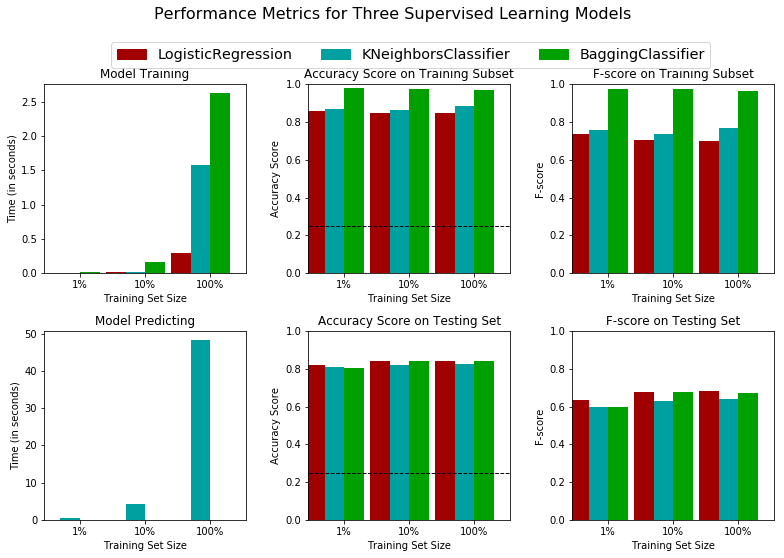

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier

# Initialize the three models
clf_A = LogisticRegression(random_state=21)
clf_B = KNeighborsClassifier()
clf_C = BaggingClassifier(random_state=21)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(round(samples_100/10))
samples_1 = int(round(samples_100/100))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [21]:
print(results['LogisticRegression'][0])
print(results['LogisticRegression'][1])
print(results['LogisticRegression'][2])
print("----------------------------")
print(results['KNeighborsClassifier'][0])
print(results['KNeighborsClassifier'][1])
print(results['KNeighborsClassifier'][2])
print("----------------------------")
print(results['BaggingClassifier'][0])
print(results['BaggingClassifier'][1])
print(results['BaggingClassifier'][2])

{'train_time': 0.009125471115112305, 'pred_time': 0.008405208587646484, 'acc_train': 0.85999999999999999, 'acc_test': 0.82056384742951904, 'f_train': 0.73863636363636354, 'f_test': 0.63369135104578855}
{'train_time': 0.02227926254272461, 'pred_time': 0.004289388656616211, 'acc_train': 0.84666666666666668, 'acc_test': 0.83880597014925373, 'f_train': 0.703125, 'f_test': 0.67809482478029737}
{'train_time': 0.2926473617553711, 'pred_time': 0.003023386001586914, 'acc_train': 0.84666666666666668, 'acc_test': 0.841901603095633, 'f_train': 0.69852941176470584, 'f_test': 0.68316522824165538}
----------------------------
{'train_time': 0.0028944015502929688, 'pred_time': 0.5878970623016357, 'acc_train': 0.87, 'acc_test': 0.80740740740740746, 'f_train': 0.75704225352112664, 'f_test': 0.60002264236386282}
{'train_time': 0.015117883682250977, 'pred_time': 4.34424901008606, 'acc_train': 0.86333333333333329, 'acc_test': 0.81956882255389718, 'f_train': 0.73630136986301375, 'f_test': 0.6308486608583413

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

**Answer: ** 
> Overall, each algorithm performed very similarly and had around the same accuracy and f scores. The algorithms mostly differed in the training and prediction time. When using 100% of the training data the fastest training time belonged to the Logistic Regression model. The slowest training time belongs to the Ensemble Bagging Classifier. It is also important to note that with 10% and 1% training data the K-NN model had the fastest training time as expected. Furthermore, the model with the fastest prediction time was also Logistic Regression. The K-NN model had the slowest prediction time as expected due to it being a lazy learner.
    
> In terms of accuracy score the Logistic Regression model only slightly beat the other two models when using 100%, 10% and 1% of the training data. However, when looking at the F-scores there was a greater difference between the lowest score belonging to K-NN and the other two models. Logistic Regression and the Bagging Classifier had similar scores but Logistic Regression obtained slightly higher scores regardless of the percentage of training data used. Using 100% of the training data K-NN had an F-score of 0.639, Bagging Classifier had a score of 0.67, and Logistic Regression had a score of 0.68. Therefore, because Logistic Regression has the fastest prediction and training times, and because it has the highest F-score and accuracy scores, it is the algorithm most suitable for the data.

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

**Answer: ** 
Logistic Regression guesses the probability of an event happening by spliting the data that it is given into two groups. It can only guess the probability between two events. The two groups that Logistic Regression created correspond to these two events. If we want to predict something we would give it some data and see in what group it belongs. For example, in this case it could see that usally a male makes more than 50K and a female makes less than 50K. It will split them into two different groups. If we want to predict how much a person makes, we would look at their sex and see where they belong. If we kn

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this.

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

#sklearn.linear_model.LogisticRegression(penalty=’l2’, dual=False, tol=0.0001, 
#C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, 
#random_state=None, solver=’liblinear’, max_iter=100, multi_class=’ovr’, 
#verbose=0, warm_start=False, n_jobs=1)


# Initialize the classifier
clf = LogisticRegression(random_state=21)

# Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver':['newton-cg', 'lbfgs', 'liblinear', 'saga']}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

Unoptimized model
------
Accuracy score on testing data: 0.8419
F-score on testing data: 0.6832

Optimized Model
------
Final accuracy score on the testing data: 0.8423
Final F-score on the testing data: 0.6849


### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |       0.8419      |   0.8423        |
| F-score        |       0.6832      |   0.6849        |

**Answer: ** As seen above the Optimized Model is not much better than the Unoptimized Model. The accuracy score of the Optimized Model is 0.8423 which is only 0.0004 better. The F-score of the Optimized Model is 0.6849 which is only 0.0017 better than the Unoptimized Model score. Furthermore, our naive predictor had an accuracy score of 0.2478 and an F-score of 0.2917. Our model scored better than the naive predictor in terms of accuracy and in terms of F-score.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:** The five features that I belive to be the most important for prediction would be occupation, age, education, sex, and race. The most important feature for prediction would be the occupation since certain occupations pay better than others regardless of any other feature(age, education, etc). I would rank age the second most important since there is a high correlation between the a persons age and an increase in wealth and income. This is usally due to promotions, increase experience in a field, or other factors gained through older age. Education would be third as higher education is usally linked with a higher income. However, age seems to be more important in determining wealth than education since experience is usally a better indicator for promotions and increase salary over time. The fourth feature would be sex since there has been research showing that females earn less than males. However, the pay difference may not be large enough to cause much of a difference like the other features. The last feature, race, would also follow the same logic as sex but may have less of an impact since the pay gap between races is less than the pay gap between sexes(http://www.pewresearch.org/fact-tank/2016/07/01/racial-gender-wage-gaps-persist-in-u-s-despite-some-progress/).

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

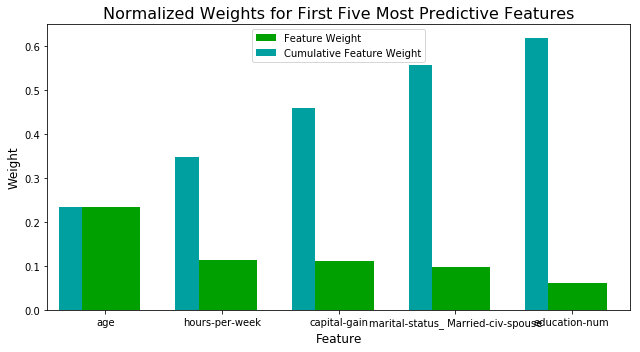

In [15]:
# Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import RandomForestClassifier

# Train the supervised model on the training set using .fit(X_train, y_train)
model = RandomForestClassifier()
model = model.fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**
The only feature that I predicted to be of most importance was age. As predicted Age is one of the most important features in terms of feature weight. It seems that capital-gain is important in determining wealth since an individual with capital-gains usally has more financial knowledge. This financial knowledge is usally linked with a greater income than those with out the ability to make capital-gains. Hours per week also seems to be relevant since a person that works more hours in a year will most likely make more money than others not working as much. Furthermore, education-num (years of education) seems to be a better predictor than education. This could possibly be because education-num gives you more information on the person's education since it's in years and not in discrete values. Furthermore,years of education covers all types of education and it's not limited to a few discrete values. Relationship also seems to be a important feature possible due the fact that a dual income will determine a higher income for those in the relationship.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [ ]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:** The final model's accuracy with the reduced data is 0.8229 which is 0.0194 lower than it's score of 0.8423 on the full data. It's F-score was also lower with a score of 0.6400 for the reduced data. This is a 0.0449 decrease from it's F-score of 0.6849 with the full data. However, if training time was a factor I would consider using the reduced data since there is not much of a difference in the scores. In this particular case, the speed between using the full data and reduced data does not differ by much. One would consider using reduced data for speed when the data that is being used is large enough to effect training time.